# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка и изучение данных

Импорт библиотек `pandas`, `numpy`, `lightgbm` и `matplotlib`, а также необходимых функций из библиотеки `sklearn`:

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

Отключим вывод предупреждений.

In [2]:
import warnings
warnings.filterwarnings('ignore')

Чтение csv-файла и вывод первых 10 строк датасета:

In [3]:
df = pd.read_csv('/datasets/autos.csv')
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Вывод информации о первой таблице методами `info()` и `describe()`.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df.describe(include='all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


Построим гистограмму для каждого столбца.

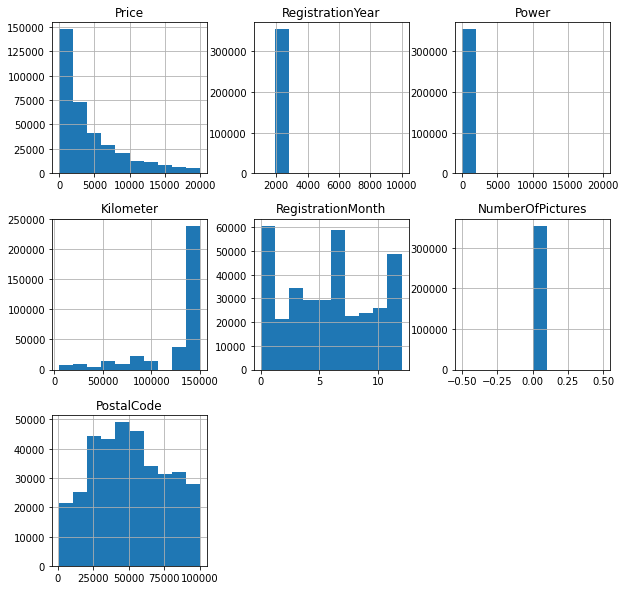

In [6]:
df.hist(figsize=(10, 10))
plt.show()

В некоторых столбцах есть пропуски, которые для обучения можели необходимо устранить. Также не все признаки информативны, эти признаки необходимо удалить. В столбцах есть аномальные значения, например в `RegistrationYear`— год регистрации автомобиля, минимальное значение 1000, максимальное - 9999. Выбросы также необходимо устранить.

### Предобработка данных

Проверим данные на наличие дубликатов.

In [7]:
df.duplicated().sum()

4

Удалим повторяющиеся строки.

In [8]:
df = df.drop_duplicates()

Рассмотрим столбцы, в которых есть пропуски.

In [9]:
df.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Пропуски в столбцах `VehicleType` - тип автомобильного кузова и `Model` - модель автомобиля заменим на значение `other`.

In [10]:
df['VehicleType'] = df['VehicleType'].fillna('other')

In [11]:
df['Model'] = df['Model'].fillna('other')

В столбцах `Gearbox` - тип коробки передач и `Repaired` - была машина в ремонте или нет пропуски заменим на неопределенный тип - `undefined`.

In [12]:
df['Gearbox'] = df['Gearbox'].fillna('undefined')

In [13]:
df['Repaired'] = df['Repaired'].fillna('undefined')

Проверим, все ли пропуски устранены.

In [14]:
df.isnull().sum()

DateCrawled              0
Price                    0
VehicleType              0
RegistrationYear         0
Gearbox                  0
Power                    0
Model                    0
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired                 0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Пропусков в столбцах нет. Столбец `FuelType` на стоимость сильно не влияет, его далее удалим.

Также необходимо устранить выбросы. Стобцы с количественными значениями - `Price`, `RegistrationYear`, `Power` и `Kilometer`. Построим для каждого столбца диаграмму размаха.

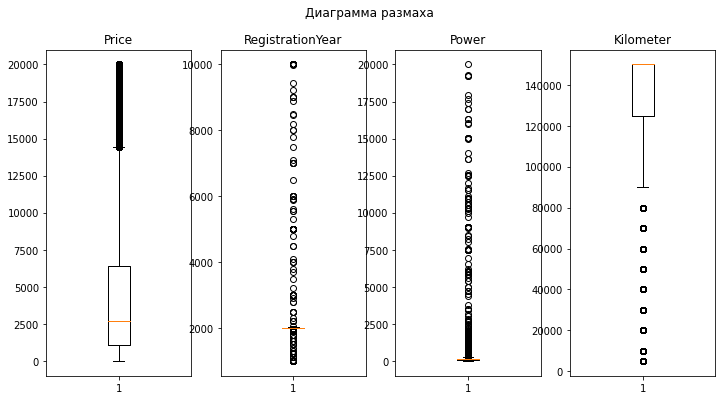

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 6))
axs[0].boxplot(df['Price'])
axs[0].set_title('Price')
axs[1].boxplot(df['RegistrationYear'])
axs[1].set_title('RegistrationYear')
axs[2].boxplot(df['Power'])
axs[2].set_title('Power')
axs[3].boxplot(df['Kilometer'])
axs[3].set_title('Kilometer')
plt.suptitle('Диаграмма размаха')
plt.show()

Удалим те строки, в которых значение столбца `RegistrationYear` меньше 1950 и больше 2019.

In [16]:
df = df[(df['RegistrationYear'] >= 1950) & (df['RegistrationYear'] <= 2019)]

Если год регистрации больше года размещения, заменим его на год размещения.

In [17]:
df.loc[df['RegistrationYear'] > pd.to_datetime(df['DateCreated']).dt.year, 'RegistrationYear'] = pd.to_datetime(df['DateCreated']).dt.year

Удалим столбцы, которые не влияют на стоимость авто - `DateCrawled`, `RegistrationMonth`, `FuelType`, `DateCreated`, `NumberOfPictures`, `PostalCode` и `LastSeen`.

In [18]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 'FuelType', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

Удалим те строки, в которых значение столбца `Price` меньше 100.

In [19]:
df = df[df['Price'] >= 100]

В столбце `Power` значения больше 5000 разделим на 100, а значения больше 1000 - на 10.

In [20]:
df.loc[df['Power'] >= 5000, ['Power']] /= 100
df.loc[df['Power'] >= 1000, ['Power']] /= 10

Нули в столбце `Power` заменим на для удобства заменим на `NaN`.

In [21]:
df.loc[df['Power'] == 0, 'Power'] = np.nan

Найдем медиану для пропущенных знначений по марке, модели и году регистрации и приравняем пропуски к ней.

In [22]:
df['Power'] = df.groupby(['Brand', 'Model', 'RegistrationYear'])['Power'].apply(lambda x: x.fillna(x.median()))

Удалим пропуски, для которых расчитать медиану не удалось.

In [23]:
df = df.dropna()

Далее в столбце `Power` округлим значения до целого, тип столбца изменим на `int`.

In [24]:
df['Power'] = round(df['Power'])
df['Power'] = df['Power'].astype('int64')

Строки, где значение `Power` больше 300 удалим и меньше 40.

In [25]:
df = df[(df['Power'] <= 300) & (df['Power'] >= 40)]

Столбец `Kilometer` оставим как есть.

Расчет процента удаленных данных:

In [26]:
print(f'{(1 - df.shape[0]/354369):.2%}')

5.26%


После изменения исходной таблица сбросим индексы.

In [27]:
df = df.reset_index(drop=True)

### Прямое и порядковое кодирование признаков

Прямое кодирование признаков подходит для линейных моделей, а порядковое для моделей деревьев. Используем оба метода.

В датасете есть столбцы с категориальными признаками - `VehicleType`, `Gearbox`, `Model`, `Brand` и `Repaired`. Для обучения модели эти признаки необходимо кодировать. Для преобразования категориальных признаков в числовые будем использовать OHE (One-Hot Encoding), прямое кодирование.

In [28]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe = df_ohe.drop(['Price'], axis=1)

Для моделей, основанных на деревьях решений, используем Ordinal Encoding - порядковое кодирование. Этот метод позволяет закодировать цифрами выраженные в тексте категории.

In [29]:
# список катешгориальных признаков
cat_features = ['VehicleType', 'Gearbox', 'Model', 'Brand', 'Repaired']

In [30]:
encoder = OrdinalEncoder()
df_ordinal = df.copy(deep=True)
df_ordinal[cat_features] = pd.DataFrame(encoder.fit_transform(df_ordinal[cat_features]), columns=cat_features)
df_ordinal = df_ordinal.drop(['Price'], axis=1)

### Разбиение данных на выборки

Разделим датасет на `features` - признаки и `target` - целевой признак.

In [31]:
features = df.drop(['Price'], axis=1)
target = df['Price']

Далее `features` и `target` разделим на обучающую и тестовую выборки в соотношении 75:25.

In [32]:
features_train, features_test, target_train, target_test = \
train_test_split(features, target, test_size=0.25, random_state=12345)

Проверим размер получившихся выборок.

In [33]:
print(f'Размер features_train: {features_train.shape} и target_train: {target_train.shape}')
print(f'Размер features_test: {features_test.shape} и target_test: {target_test.shape}')

Размер features_train: (251806, 8) и target_train: (251806,)
Размер features_test: (83936, 8) и target_test: (83936,)


Таким образом, исходный датасет разделен верно.

Также необходимо создать выборки с кодированными признаками.

In [34]:
features_train_ohe = df_ohe.loc[features_train.index]
features_test_ohe = df_ohe.loc[features_test.index]

In [35]:
features_train_ordinal = df_ordinal.loc[features_train.index]
features_test_ordinal = df_ordinal.loc[features_test.index]

### Масштабирование признаков

Так как в данных присутствуют колличественные признаки с разными разбросами значений, например, такие столбцы как `Power` и `Kilometer`, масштабируем признаки. Стандартизируем признаки с помощью `StandardScaler`.

In [36]:
# список количественных признаков
numeric = ['RegistrationYear', 'Power', 'Kilometer']

In [37]:
pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])

features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

## Обучение моделей

Рассмотрим четыре модели - две модели бустинга: `LightGBM` и `CatBoostRegressor`, а также модели `LinearRegression` - линейной регрессии и `DecisionTreeRegressor` - модель решающего дерева.

Для моделей бустинга создадим список категориальных признаков и изменим их тип на `category`.

In [38]:
features_train[cat_features] = features_train[cat_features].astype('category')
features_test[cat_features] = features_test[cat_features].astype('category')

Для обучения и проверки моделей используем кросс-валидацию.

### LightGBM

Подберем лучшие гиперпараметры `max_depth` и `n_estimators` для модели `LGBMRegressor` с помощью `GridSearchCV`, также используем кросс-валидацию с параметром `cv=5`.

In [39]:
%%time

lgb_model = lgb.LGBMRegressor(random_state=12345)

lgb_parametrs = {'max_depth': range(10, 16, 5), 'n_estimators': range(100, 141, 10)}

lgb_grid = GridSearchCV(lgb_model, lgb_parametrs, scoring='neg_root_mean_squared_error', cv=5)
lgb_grid.fit(features_train, target_train)

print(f'Средняя оценка RMSE лучшей модели: {abs(lgb_grid.best_score_):.2f}')
print("Глубина дерева:", lgb_grid.best_params_['max_depth'])
print("Количество деревьев:", lgb_grid.best_params_['n_estimators'])

Средняя оценка RMSE лучшей модели: 1623.30
Глубина дерева: 15
Количество деревьев: 140
CPU times: user 8min 48s, sys: 4.75 s, total: 8min 53s
Wall time: 9min


Проверим время, за которое обучается модель с полученными гиперпараметрами.

In [40]:
%%time

lgb_grid.best_estimator_.fit(features_train, target_train)

CPU times: user 1min 21s, sys: 1.05 s, total: 1min 22s
Wall time: 1min 23s


LGBMRegressor(max_depth=15, n_estimators=140, random_state=12345)

Также получим время, за которое модель предсказывает результаты на тестовой выборке.

In [41]:
%%time

lgb_grid.best_estimator_.predict(features_test)

CPU times: user 1.01 s, sys: 0 ns, total: 1.01 s
Wall time: 1.01 s


array([ 530.11536093, 1176.05380583,  569.52087199, ...,  922.6777478 ,
       4988.40164469, 1570.74781569])

### CatBoostRegressor

Подберем лучшие гиперпараметры `depth` и `iterations` для модели `CatBoostRegressor` с помощью `GridSearchCV`, также используем кросс-валидацию с параметром `cv=5`.

In [42]:
%%time

cbr_model = CatBoostRegressor(cat_features=cat_features, verbose=0)

cbr_parameters = {'depth': range(6, 11, 2), 'iterations': range(100, 151, 10)}

cbr_grid = GridSearchCV(cbr_model, cbr_parameters, scoring='neg_root_mean_squared_error', cv = 5)
cbr_grid.fit(features_train, target_train)

print(f'Средняя оценка RMSE лучшей модели: {abs(cbr_grid.best_score_):.2f}')
print("Глубина:", cbr_grid.best_params_['depth'])
print("Количество итераций:", cbr_grid.best_params_['iterations'])

Средняя оценка RMSE лучшей модели: 1612.44
Глубина: 10
Количество итераций: 150
CPU times: user 16min, sys: 6.47 s, total: 16min 7s
Wall time: 17min


Проверим время, за которое обучается модель с полученными гиперпараметрами.

In [43]:
%%time

cbr_grid.best_estimator_.fit(features_train, target_train)

CPU times: user 19.6 s, sys: 206 ms, total: 19.8 s
Wall time: 20.3 s


Также получим время, за которое модель предсказывает результаты на тестовой выборке.

In [44]:
%%time

cbr_grid.best_estimator_.predict(features_test)

CPU times: user 85.7 ms, sys: 3.9 ms, total: 89.6 ms
Wall time: 87.2 ms


array([ 559.39375884, 1111.41961104,  513.6600957 , ..., 1077.56650199,
       4842.20730981, 1712.16932069])

### DecisionTreeRegressor

Подберем лучшие гиперпараметры `max_depth` для модели `DecisionTreeRegressor` с помощью `GridSearchCV`, также используем кросс-валидацию с параметром `cv=5`.

In [45]:
%%time

dtr_model = DecisionTreeRegressor(random_state=12345)
dtr_parametrs = {'max_depth': range(10, 21)}

dtr_grid = GridSearchCV(dtr_model, dtr_parametrs, scoring='neg_root_mean_squared_error', cv=5)
dtr_grid.fit(features_train_ordinal, target_train)

print(f'Средняя оценка RMSE лучшей модели: {abs(dtr_grid.best_score_):.2f}')
print("Глубина дерева:", dtr_grid.best_params_['max_depth'])

Средняя оценка RMSE лучшей модели: 1878.11
Глубина дерева: 15
CPU times: user 26.9 s, sys: 70.9 ms, total: 26.9 s
Wall time: 27 s


Проверим время, за которое обучается модель с полученными гиперпараметрами.

In [46]:
%%time

dtr_grid.best_estimator_.fit(features_train_ordinal, target_train)

CPU times: user 585 ms, sys: 170 µs, total: 586 ms
Wall time: 591 ms


DecisionTreeRegressor(max_depth=15, random_state=12345)

Также получим время, за которое модель предсказывает результаты на тестовой выборке.

In [47]:
%%time

dtr_grid.best_estimator_.predict(features_test_ordinal)

CPU times: user 18.9 ms, sys: 0 ns, total: 18.9 ms
Wall time: 17.3 ms


array([ 836.15605096, 1324.1322314 ,  682.46355974, ..., 1230.42760181,
       4573.02083333, 1899.5477707 ])

### LinearRegression

Рассмотрим модель `LinearRegression` - линейная регрессия. Для получения оценки модели используем кросс-валидацию с параметром `cv=5`.

In [48]:
lr_model = LinearRegression()

Получим время обучения модели и оценку модели.

In [49]:
%%time

lr_model.fit(features_train_ohe, target_train)

CPU times: user 16.7 s, sys: 9.35 s, total: 26 s
Wall time: 26.1 s


LinearRegression()

In [50]:
lr_scores = cross_val_score(lr_model, features_train_ohe, target_train, cv=5, scoring='neg_root_mean_squared_error')
lr_score_final = abs(lr_scores).mean()

print(f'Средняя оценка RMSE модели: {lr_score_final:.2f}')

Средняя оценка RMSE модели: 2632.41


Время предсказания модели.

In [51]:
%%time

lr_model.predict(features_test_ohe)

CPU times: user 115 ms, sys: 76.4 ms, total: 192 ms
Wall time: 290 ms


array([ -240.48109171,   945.7336599 , -1119.38196216, ...,
         588.55044105,  6008.62289821,  3557.33523228])

## Анализ моделей

Построим сводную таблицу по результатам обучения всех моделей.

In [54]:
columns = ['RMSE', 'fit time, s', 'predict time, ms']
index = ['LGBMRegressor', 'CatBoostRegressor', 'DecisionTreeRegressor', 'LinearRegression']
data = np.array([[1623.30, 83, 60], [1612.44, 20.3, 87.2], [1878.11, 9.9, 17.3], [2632.41, 26.1, 290]])
results = pd.DataFrame(data, columns=columns, index=index)
results

,RMSE,"fit time, s","predict time, ms"
LGBMRegressor,1623.30,83.0,60.0
CatBoostRegressor,1612.44,20.3,87.2
DecisionTreeRegressor,1878.11,9.9,17.3
LinearRegression,2632.41,26.1,290.0


Наименьшее значение `RMSE` у модели `CatBoostRegressor`, также у модели хорошие показатели времени обучения и предсказания. Наименьшее время обучения и прдсказания у модели `DecisionTreeRegressor` - решающего дерева, но `RMSE` больше, относительно моделей `LGBMRegressor` и `CatBoostRegressor`. 

В итоге лучшая модель - `CatBoostRegressor` с гиперпараметрами `depth=10`, `iterations=150`. Проверим качество предсказания метрикой `RMSE` на тестовой выборке.

In [53]:
predictions = cbr_grid.best_estimator_.predict(features_test)
print(f'RMSE лучшей модели на тестовой выборке: {mean_squared_error(target_test, predictions) ** (1/2):.2f}')

RMSE лучшей модели на тестовой выборке: 1603.54


Выбранная модель по качеству соответсвует условию: "Значение метрики RMSE должно быть меньше 2500".

## Общий вывод

В результате исследования были выполнены следующие шаги: подготовка данных, обучение и анализ моделей.

На этапе подготовки данных были изучены данные. Также данные были предобработаны, т. к. в некотрых столбцах были пропуски и аномальные значения. Пропуски были в категориальных признаках и были заменены на значение 'other'. Аномальные значения были удалены или замены на сгруппированное по признакам медианное значение. Некоторые столбцы из датасета были удалены, т. к. они не влияют на стоимость автомобиля. Для обучения моделей решающего дерева и линейной регрессии категориальные признаки были кодированы техникой OHE. Далее данные были разделены на признаки и целевой признак, затем были созданы обучающая и тестовая выборки.

На этапе обучения и анализа моделей были рассмотрены четыре модели, две из которых модели градиентного бустинга. Для каждой модели, кроме линейной регрессии, для поиска лучших гиперпараметров использовался GridSearchCV, также при обучении и проверки моделей использовалась кросс-валидация. Параметры оценки и выбора лучшей модели следующие: качество предсказания, время обучения модели, время предсказания модели. Для всех моделей по всем парметрам была построена сводная таблица. Наилучшие значения у модели CatBoostRegressor с гиперпараметрами depth=10, iterations=150. У нее наименьшее время обучения и предсказания, а также высокое качество, в сравнении с остальными моделями. RMSE модели на тестовой выборке равно 1603.54.